In [32]:
import numpy as np
import matplotlib.pyplot as plt
import os
# import evaluation as ev
from skimage.measure import compare_psnr as psnr
from skimage.measure import compare_ssim as ssim
plt.rcParams['image.cmap'] = 'gray'

import numpy as np

# Mean Absolute Error
def computeMAE(real_scan, rec_scan):
    assert(real_scan.shape == rec_scan.shape)
    return np.sum(np.abs(real_scan - rec_scan)).mean()


# Mean Squared error
def computeMSE(real_scan, rec_scan):
    assert(real_scan.shape == rec_scan.shape)
    return np.square((real_scan - rec_scan)).mean()


# Peak Signal to Noise Ratio
def computePSNR(real_scan, rec_scan):
    # scan was normalised to [1, -1], so peak value is 1
    peak = 1.0
    return 20 * np.log10(peak / np.sqrt(computeMSE(real_scan, rec_scan)))


# path to test data
test_path = './data/visceral_full/test'

seg_path = './data/visceral_full/test/annotations'

# path to test results
res_path = '../pytorch-CycleGAN-and-pix2pix/results/ct_mr_visceral_spine_2'

test_files = [ p for p in os.listdir(test_path) if 'npz' in p]
res_files = [ p for p in os.listdir(res_path) if 'rec' in p]
print(test_files, len(test_files))
print(res_files, len(res_files))
print(os.listdir(seg_path))

['10000005_1_CT_wb.npz', '10000135_1_CTce_ThAb.npz', '10000136_1_CTce_ThAb.npz', '10000365_4_MRT1cefs_Ab.npz', '10000003_3_MRT1_wb.npz', '10000006_1_CT_wb.npz', '10000381_4_MRT1cefs_Ab.npz', '10000001_3_MRT1_wb.npz'] 8
['rec_10000365_4_MRT1cefs_Ab.npz', 'rec_10000381_4_MRT1cefs_Ab.npz', 'rec_10000003_3_MRT1_wb.npz', 'rec_10000001_3_MRT1_wb.npz', 'rec_10000136_1_CTce_ThAb.npz', 'rec_10000005_1_CT_wb.npz', 'rec_10000135_1_CTce_ThAb.npz', 'rec_10000006_1_CT_wb.npz'] 8
['10000005_1_CT_wb.npz', '10000135_1_CTce_ThAb.npz', '10000136_1_CTce_ThAb.npz', '10000365_4_MRT1cefs_Ab.npz', '10000003_3_MRT1_wb.npz', '10000006_1_CT_wb.npz', '10000381_4_MRT1cefs_Ab.npz', '10000001_3_MRT1_wb.npz']


In [33]:
def display_slice(scan, slice_num):
    plt.figure(figsize=(10, 10))
    plt.imshow(scan[:, slice_num, :])
    plt.show()

def normalise_zero_mean_unit_var(arr):
    mean = arr.mean()
    std = arr.std()
    return (arr - mean) / std, mean, std


def denormalise_zero_mean_unit_var(arr, mean, std):
    return arr * std + mean


# normalise to [-1 1]
def normalise_tanh(arr):
    min_val = np.min(arr)
    max_val = np.max(arr)
    return 2 * ((arr - np.min(arr)) / (np.max(arr) - np.min(arr))) - 1, min_val, max_val


def denormalise_tanh(arr, min_val, max_val):
    return ((arr + 1) / 2) * (max_val - min_val) + min_val


# center data and normalise to -1 and 1
def normalise_scan(scan):
    # set data to zero mean and unit variance
    normalised_scan, mean, std = normalise_zero_mean_unit_var(scan)
    
    # normalise to -1 and 1
    # min_val and max_val are the min and max values of normalised numpy array
    normalised_scan, min_val, max_val = normalise_tanh(normalised_scan)
    return normalised_scan, mean, std, min_val, max_val


def denormalise_scan(nrml_scan, mean, std, min_val, max_val):
    denormalised = denormalise_tanh(nrml_scan, min_val, max_val)
    return denormalise_zero_mean_unit_var(denormalised, mean, std)


In [50]:
maes = []
psnrs = []

for p in test_files:
    test_file = '{}/{}'.format(test_path, p)
    seg_file = '{}/{}'.format(seg_path, p)
    res_file = '{}/rec_{}'.format(res_path, p)
    seg = np.load(seg_file)['data']
    mask = np.where(seg == 0, seg, 1)
    
    test = np.load(test_file)['data']
    res = np.load(res_file)['data']
    
    # denormalise
    mean = np.load(test_file)['mean']
    std = np.load(test_file)['std']
    min_val = np.load(test_file)['min_val']
    max_val = np.load(test_file)['max_val']
    
    test = denormalise_scan(test, mean, std, min_val, max_val)
    res = denormalise_scan(res, mean, std, min_val, max_val)
    
    # apply mask
    test = np.multiply(mask, test)
    res = np.multiply(mask, res)
    
    # compute MAE
    mae_res = computeMAE(test, res)
    
    # compute PSNR
    # psnr_res = computePSNR(test, res)
    
    psnr_res = psnr(test, res, np.max(test) - np.min(test))
    
    ssim_res = ssim(test, res)
    
    maes.append(mae_res)
    psnrs.append(psnr_res)
    
    # display middle slice (coronal)
#     mid = test.shape[1] // 2
#     display_slice(test, mid)
#     display_slice(res, mid)
    
    print(p, mae_res, psnr_res, ssim_res)


10000005_1_CT_wb.npz 925864450.0 30.48246914420983 0.7599897197482931
10000135_1_CTce_ThAb.npz 1274778100.0 21.755834646048065 0.7654645362311931
10000136_1_CTce_ThAb.npz 950430900.0 25.526831055735876 0.8021289344892795
10000365_4_MRT1cefs_Ab.npz 411074601.8527565 18.987949050633336 0.8830622743488397
10000003_3_MRT1_wb.npz 807745184.8839111 19.24187037542095 0.8660906118720013
10000006_1_CT_wb.npz 386582820.0 33.351595729596134 0.7893524482247265
10000381_4_MRT1cefs_Ab.npz 277181265.4834404 22.67719135970225 0.7767833494265768
10000001_3_MRT1_wb.npz 471042267.54101944 24.63434392765352 0.8683925423931049


In [51]:
"""
10000005_1_CT_wb.npz 925864450.0 30.48246914420983 0.7599897197482931
10000135_1_CTce_ThAb.npz 1274778100.0 21.755834646048065 0.7654645362311931
10000136_1_CTce_ThAb.npz 950430900.0 25.526831055735876 0.8021289344892795
10000365_4_MRT1cefs_Ab.npz 411074601.8527565 18.987949050633336 0.8830622743488397
10000003_3_MRT1_wb.npz 807745184.8839111 19.24187037542095 0.8660906118720013
10000006_1_CT_wb.npz 386582820.0 33.351595729596134 0.7893524482247265
10000381_4_MRT1cefs_Ab.npz 277181265.4834404 22.67719135970225 0.7767833494265768
10000001_3_MRT1_wb.npz 471042267.54101944 24.63434392765352 0.8683925423931049
"""

maes = np.array(maes)
psnrs = np.array(psnrs)
    
print('Averages - MAE: {}, PSNR, {}'.format(maes.mean(), psnrs.mean()))
print('Std - MAE: {}, PSNR, {}'.format(maes.std(), psnrs.std()))

Averages - MAE: 688087450.9701409, PSNR, 24.582260661124998
Std - MAE: 329294618.33066654, PSNR, 4.796387800273015


## what does the data and reconstructed data look like?

In [43]:
def display_slice(scan, slice_num):
    plt.figure(figsize=(10, 10))
    # 30 - 120 600, 1150, 210, 310, 50, 370
    plt.imshow(scan[:, slice_num, :])
    plt.show()

test_scan = np.load(test_path + '/10000136_1_CTce_ThAb.npz')
mean = test_scan['mean']
std = test_scan['std']
min_val = test_scan['min_val']
max_val = test_scan['max_val']
test_scan = test_scan['data']
test_scan = denormalise_scan(test_scan, mean, std, min_val, max_val)

res_scan = np.load(res_path + '/rec_10000136_1_CTce_ThAb.npz')['data']
seg_scan = np.load(seg_path + '/10000136_1_CTce_ThAb.npz')['data']

print(test_scan.shape, seg_scan.shape)

mask = np.where(seg_scan == 0, seg_scan, 1)

print(np.min(test_scan), np.max(test_scan))

(590, 110, 300) (590, 110, 300)
-1038.7924 2957.5806


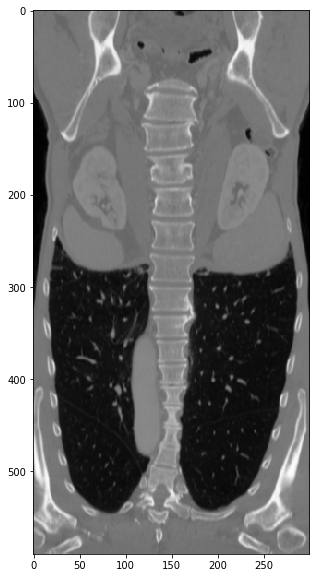

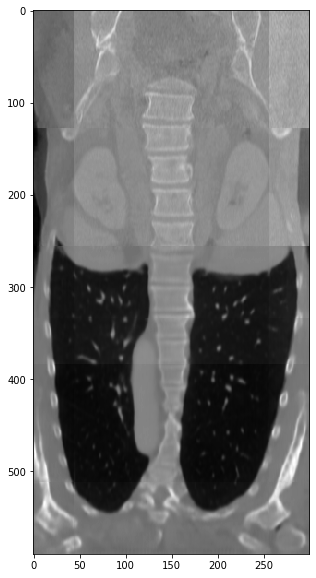

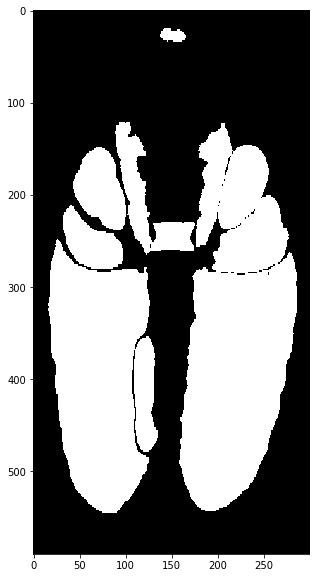

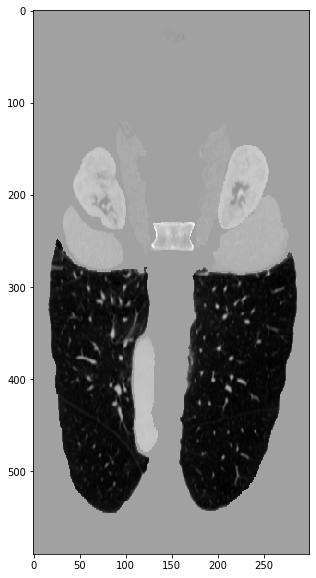

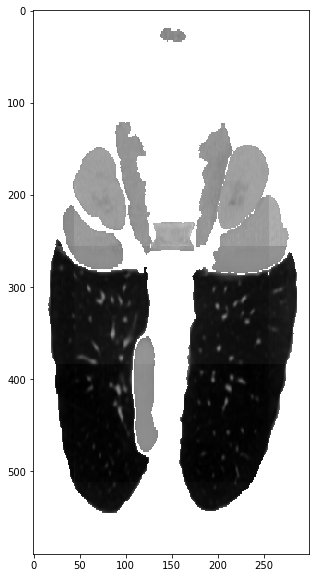

In [40]:
slice_num = 40
display_slice(test_scan, slice_num)
display_slice(res_scan, slice_num)
display_slice(mask, slice_num)
display_slice(np.multiply(mask, test_scan), slice_num)
display_slice(np.multiply(mask, res_scan), slice_num)

In [27]:
5 //2

2